In [1]:
# 📦 Import basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🛠️ Prophet model
from prophet import Prophet


In [12]:
# 📥 Load dataset
df = pd.read_csv('sales_data_sample.csv', encoding='latin1')


# 🔍 Preview the first rows
df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [13]:
# 📅 Convert the ORDERDATE column to datetime format
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# ✅ Confirm that conversion worked
df[['ORDERDATE']].head()


,ORDERDATE
0,2003-02-24
1,2003-05-07
2,2003-07-01
3,2003-08-25
4,2003-10-10


## 📥 Step 1 – Load and Prepare the Sales Dataset

We start by loading a real-world retail sales dataset.  
This file contains individual order-level data with fields such as `ORDERDATE`, `SALES`, `QUANTITYORDERED`, and more.

For time series forecasting, we focus on:
- `ORDERDATE`: to extract the time axis (we convert it to datetime format)
- `SALES`: the value we want to forecast

Later, we will group sales by date to create a clean time series for the Prophet model.


In [14]:
# 📊 Group sales data by date
# We sum the 'SALES' column for each unique date in 'ORDERDATE'
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()


In [15]:
# 📅 Prophet requires columns named 'ds' for date and 'y' for value
# We rename accordingly
daily_sales.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)

# 👀 Preview the new DataFrame
daily_sales.head()


,ds,y
0,2003-01-06,12133.25
1,2003-01-09,11432.34
2,2003-01-10,6864.05
3,2003-01-29,54702.00
4,2003-01-31,44621.96


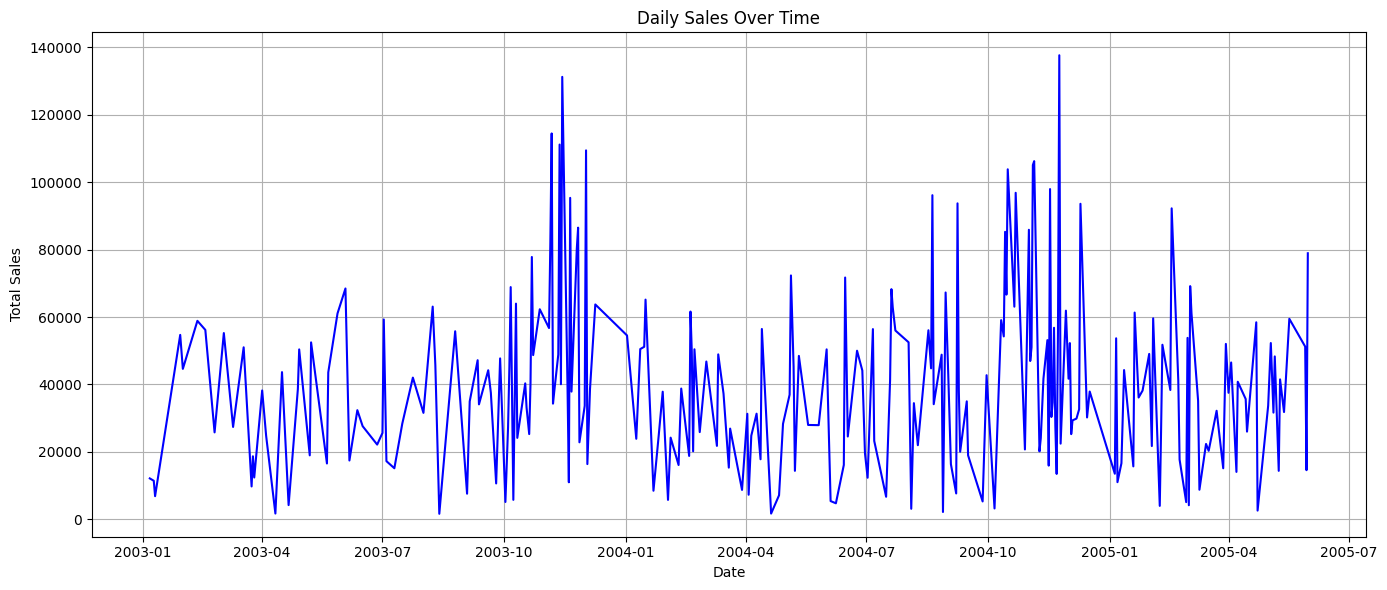

In [16]:
# 📈 Line plot: Daily sales over time
plt.figure(figsize=(14,6))
sns.lineplot(data=daily_sales, x='ds', y='y', color='blue')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Step 2 – Aggregate Sales by Date & Visualize

We aggregated sales on a daily level using the `ORDERDATE` and `SALES` columns.

Prophet requires the following structure:
- `ds`: datetime column
- `y`: numeric value to forecast (sales)

We renamed the columns and visualized the daily trend.  
As seen in the plot, sales show a highly variable pattern with notable peaks during certain months — potentially due to seasonality or promotion periods.

This initial trend analysis helps identify spikes, dips, and overall distribution before modeling.


In [17]:
# 🔮 Initialize Prophet model
model = Prophet()

# 🧠 Fit the model on our daily sales data
model.fit(daily_sales)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpibigkcn7/p8sab49s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpibigkcn7/i6y1jep8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70757', 'data', 'file=/tmp/tmpibigkcn7/p8sab49s.json', 'init=/tmp/tmpibigkcn7/i6y1jep8.json', 'output', 'file=/tmp/tmpibigkcn7/prophet_modely3dv7wxd/prophet_model-20250723183250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
# 📅 Create a future dataframe with 90 extra days
future = model.make_future_dataframe(periods=90)

# 🔮 Predict future sales
forecast = model.predict(future)

# 👀 Preview forecast dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
337,2005-08-25,52252.996669,21918.932743,80838.060459
338,2005-08-26,50261.486899,23398.639718,82950.498042
339,2005-08-27,34326.585280,5102.222441,63432.758511
340,2005-08-28,55113.155945,25807.009763,83890.258973
341,2005-08-29,42631.863505,12192.794807,70531.012902


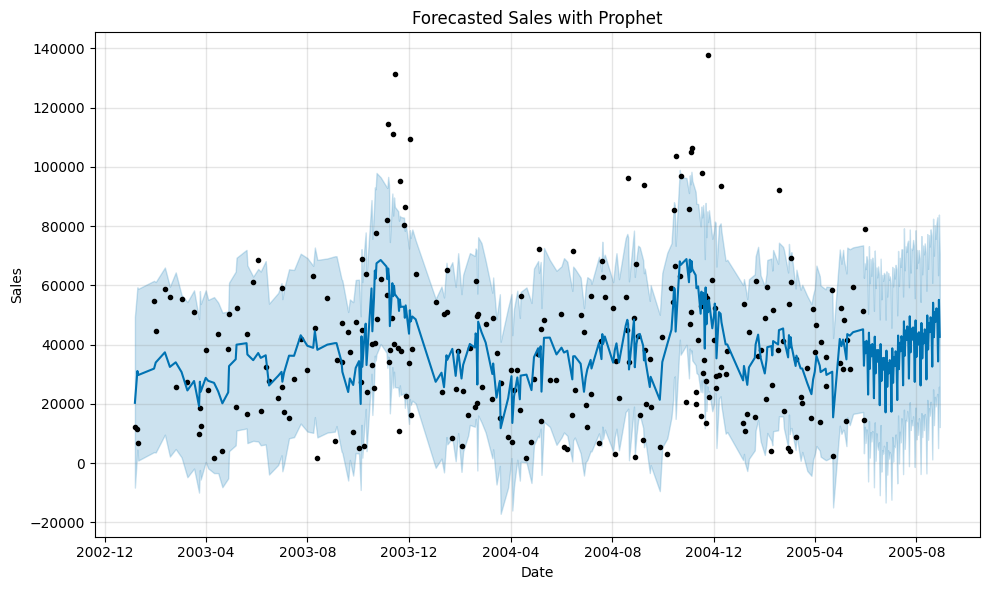

In [19]:
# 📈 Plot the forecast (includes trend + confidence intervals)
fig1 = model.plot(forecast)
plt.title('Forecasted Sales with Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


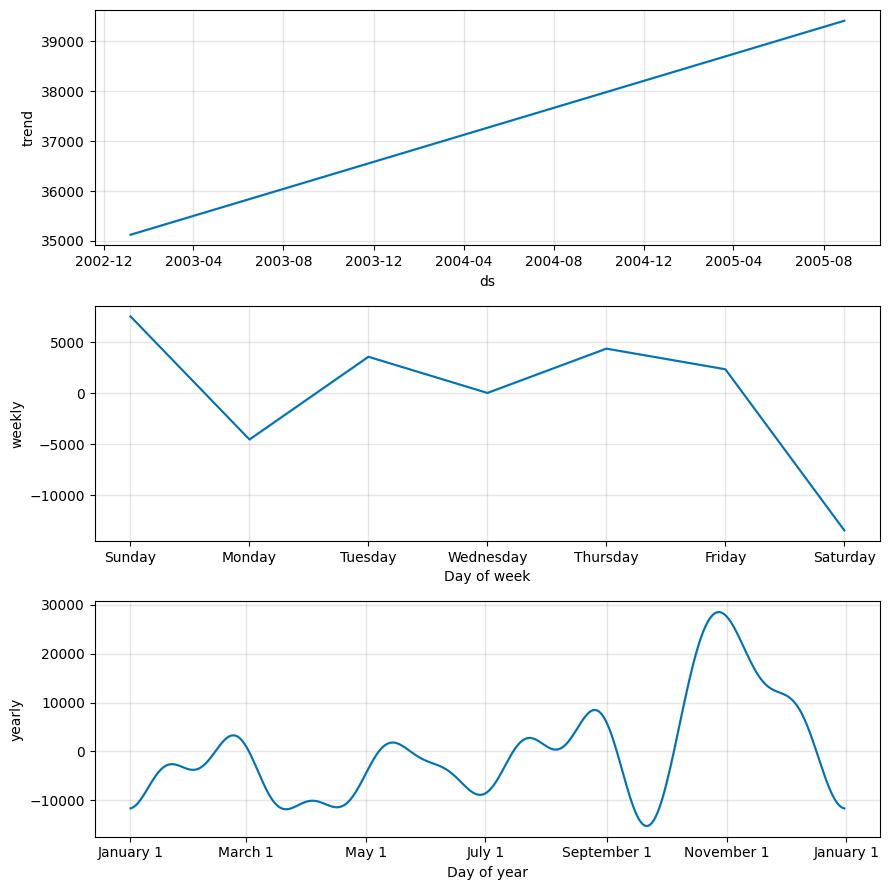

In [20]:
# 🔍 Plot components: trend, weekly and yearly seasonality
fig2 = model.plot_components(forecast)
plt.tight_layout()


## 🔮 Step 3 – Forecasting with Prophet

Using Facebook Prophet, we trained a time series model on daily sales data and extended the forecast 90 days into the future.

### Key Results:
- The forecast shows expected sales values (`yhat`) along with uncertainty intervals.
- Despite noisy behavior, the model captures seasonal spikes and longer-term trends.

### Seasonality Insights:
- **Trend**: Slightly increasing overall
- **Weekly**: Sales dip on Mondays and Saturdays, peak mid-week
- **Yearly**: Strong upward demand in November–December, likely holiday-driven

This forecast enables better planning and resource allocation for sales-heavy periods.


---

## ✅ Final Thoughts

This project showcased a full end-to-end time series forecasting pipeline using real-world retail sales data.

We:
- Cleaned and aggregated raw sales data
- Visualized trends and seasonal patterns
- Built a forecast using **Facebook Prophet**
- Interpreted weekly and yearly seasonality
- Identified demand spikes and downturns to inform business strategy

📌 This kind of analysis is valuable for:
- **Inventory and supply chain planning**
- **Marketing campaign timing**
- **Retail performance monitoring**

---

 Thanks for reading!  
